In [19]:
import torch
import corner
import numpy as np
import pylab as plt
from swyft.intensity import BallMask, ComboMask, Prior1d, Prior, IntensityNew
from tqdm import tqdm

import swyft

DEVICE = 'cuda'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def model(par):
    return dict(spec=np.linspace(-1, 1, 5)*par['A']+par['B'])

def noise(obs, par):
    obs['spec'] += np.random.randn(*obs['spec'].shape)*0.5
    return obs

### Storage

In [21]:
cache = swyft.MemoryCache(par_names = ["A", "B"], obs_shapes = {"spec": (5,)})

Creating new cache.


### Prior

In [22]:
prior_conf = {"A": ["normal", 0.0, 1.0], "B": ["normal",  0., 1.0]}
prior = Prior(prior_conf)

### Populating storage with simulations

In [23]:
N = 3000
cache.grow(prior, N)
cache.simulate(model)

Simulate:   1%|▏         | 39/2925 [00:00<00:07, 385.94it/s]

Adding 2925 new samples. Run simulator!


Simulate: 100%|██████████| 2925/2925 [00:07<00:00, 386.32it/s]


In [24]:
indices = cache.sample(prior, N)
points = swyft.Points(cache, indices, noise)

In [29]:
re = swyft.RatioEstimator(points, [("A"), ("B"), ("A", "B")], device=DEVICE)
re.train(max_epochs=10, batch_size=8, lr_schedule=[1e-3, 1e-4])

Automatic transformation
Number of features from head network: 5
Number of parameters to estimate: 3
Maximum posterior dimensionality: 2
Start training
LR iteration 0
Validation loss: 148.2859673500061
Validation loss: 150.84847974777222
Total epochs: 2
LR iteration 1
Validation loss: 138.98909258842468
Validation loss: 138.7181851863861
Validation loss: 141.75496172904968
Total epochs: 3


In [30]:
obs0, par0 = points[2]['obs'], points[2]['par']

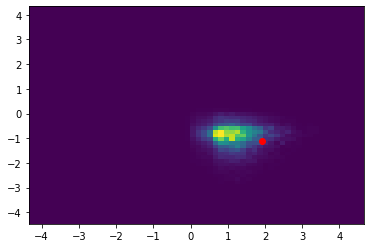

In [31]:
pars = prior.sample(100000)
lnL = re.lnL(obs0, pars)
plt.hist2d(pars['A'], pars['B'], weights = np.exp(lnL[('A', 'B')]), bins = 60, density = True);
plt.scatter(par0['A'], par0['B'], marker='o', color='r')

In [32]:
prior2 = prior.get_masked(obs0, re)

In [33]:
cache.grow(prior2, N)
cache.simulate(model)

Simulate:   2%|▏         | 39/2264 [00:00<00:05, 388.12it/s]

Adding 2264 new samples. Run simulator!


Simulate: 100%|██████████| 2264/2264 [00:05<00:00, 380.76it/s]


In [34]:
indices = cache.sample(prior2, N)
points = swyft.Points(cache, indices, noise)

In [35]:
re = swyft.RatioEstimator(points, [("A"), ("B"), ("A", "B")], device=DEVICE)
re.train(max_epochs=10, batch_size=8, lr_schedule=[1e-3, 1e-4])

Number of features from head network: 5
Number of parameters to estimate: 3
Maximum posterior dimensionality: 2
Start training
LR iteration 0
Validation loss: 212.55216360092163
Validation loss: 199.56980514526367
Validation loss: 201.05320811271667
Total epochs: 3
LR iteration 1
Validation loss: 199.34226298332214
Validation loss: 194.37027716636658
Validation loss: 194.38472986221313
Total epochs: 3


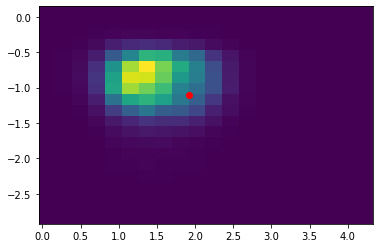

In [36]:
pars = prior2.sample(100000)
lnL = re.lnL(obs0, pars)
plt.hist2d(pars['A'], pars['B'], weights = np.exp(lnL[('A', 'B')]), bins = 20, density = True);
plt.scatter(par0['A'], par0['B'], marker='o', color='r')